# MÔ HÌNH HÓA DỮ LIỆU
- **VỀ DỮ LIỆU:** Dữ liệu được thu thập thêm từ thông tin chi tiết của các địa điểm của một quốc gia. Có các cột là giá trị các thông tin chi tiết đó. Và có một cột target chính là kết quả mà ta sẽ suy ra từ bộ dữ liệu input. Dữ liệu có thể được cập nhật theo ngày tháng, do đó dữ liệu sẽ gần như vô hạn. Tuy nhiên, ta chỉ dùng một ngày cố định, thường sẽ dùng today().
- **VỀ MÔ HÌNH:** Ta sẽ chọn 2 mô hình:
  - Mô hình gom nhóm Random Forest.
  - Mô hình hồi quy tuyến tính Logitis Regression.

In [24]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện hỗ trợ thêm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Đọc file input dữ liệu:

- Ta có thể lấy dữ liệu gần nhất, dữ liệu today()
- Ta có thể lấy dữ liệu các ngày đã thu thập.

In [25]:
from os import walk
filenames = next(walk('./data/data'), (None, None, []))[2]  # [] if no file

# Nếu muốn train trên bộ dữ liệu là ngày hôm nay today()
# filename = filenames[-1]
# df = pd.read_csv(f'./data/data/{filename}')

# Nếu muốn test trên bộ dữ liệu là các ngày mà ta thu thập...
cnt = 0
for filename in filenames:    
    if cnt == 0:
        df = pd.read_csv(f'./data/data/{filename}')
    else:
        df = pd.concat([df, pd.read_csv(f'./data/data/{filename}')])
    cnt += 1
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,target,CO
0,Trời quang,18°C,29%,10.1 km/h,1014 mbar,62.8,279,3,100,28.8,Không lành mạnh,NaN
1,Trời quang,19°C,23%,11.2 km/h,1013 mbar,75.1,277,10,79.2,9.6,Không lành mạnh,1720.0
2,Nhiều mây,-1°C,45%,7 km/h,1032 mbar,109,477.5,56.5,31,8.5,Nguy hiểm,450.0
3,Sương mù,19°C,45%,5.5 km/h,1014 mbar,87,NaN,NaN,NaN,NaN,Không lành mạnh,NaN
4,Trời quang,21°C,32%,10.6 km/h,1012 mbar,52.2*,NaN,NaN,NaN,NaN,Không lành mạnh cho các nhóm nhạy cảm,NaN


In [26]:
df['target'].value_counts()

Tốt                                      1070
Trung bình                                525
Không lành mạnh cho các nhóm nhạy cảm     197
Không lành mạnh                           165
Rất không lành mạnh                        23
Nguy hiểm                                  17
Name: target, dtype: int64

Quy các kiểu dữ liệu `string` về thành `int` để có thể tính mean

In [27]:
weather = ['Nhiều mây', 'Trời quang', 'Mưa', 'Mây rải rác', 'Sương mù', 'Ít mây', 'Tuyết', 'Mưa rào', 'Giông bão']
target = ['Tốt', 'Trung bình', 'Không lành mạnh', 'Không lành mạnh cho các nhóm nhạy cảm', 
          'Rất không lành mạnh', 'Nguy hiểm']
df = df.replace(weather, np.arange(len(weather)) + 1)
df = df.replace(target, np.arange(len(target)) + 1)
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,target,CO
0,2,18°C,29%,10.1 km/h,1014 mbar,62.8,279,3,100,28.8,3,NaN
1,2,19°C,23%,11.2 km/h,1013 mbar,75.1,277,10,79.2,9.6,3,1720.0
2,1,-1°C,45%,7 km/h,1032 mbar,109,477.5,56.5,31,8.5,6,450.0
3,5,19°C,45%,5.5 km/h,1014 mbar,87,NaN,NaN,NaN,NaN,3,NaN
4,2,21°C,32%,10.6 km/h,1012 mbar,52.2*,NaN,NaN,NaN,NaN,4,NaN


Format lại các thông tin trong dữ liệu

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['Nhiệt độ'] = df['Nhiệt độ'].str.replace('°C', '')
    df['Độ ẩm'] = df['Độ ẩm'].str.replace('%', '')
    df['Gió'] = df['Gió'].str.replace(' km/h', '')
    df['Áp suất'] = df['Áp suất'].str.replace(' mbar', '')
    df[' PM2.5 '] = df[' PM2.5 '].str.replace('*', '')
    df[' PM10 '] = df[' PM10 '].str.replace('*', '')
    df[' O3 '] = df[' O3 '].str.replace('*', '')
    df[' NO2 '] = df[' NO2 '].str.replace('*', '')
    df[' SO2 '] = df[' SO2 '].str.replace('*', '')
    df[' CO '] = df[' CO '].str.replace('*', '')

In [29]:
df = df.astype(np.float64)
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,target,CO
0,2.0,18.0,29.0,10.1,1014.0,62.8,279.0,3.0,100.0,28.8,3.0,NaN
1,2.0,19.0,23.0,11.2,1013.0,75.1,277.0,10.0,79.2,9.6,3.0,NaN
2,1.0,-1.0,45.0,7.0,1032.0,109.0,477.5,56.5,31.0,8.5,6.0,NaN
3,5.0,19.0,45.0,5.5,1014.0,87.0,NaN,NaN,NaN,NaN,3.0,NaN
4,2.0,21.0,32.0,10.6,1012.0,52.2,NaN,NaN,NaN,NaN,4.0,NaN


Như đã thấy thì dữ liệu của mô hình có các giá trị NaN. Ta không thể drop các giá trị đó hoặc thay bằng 0, có nhiều cách để thay thế giá trị NaN, tuy nhiên ở đây chúng ta sẽ thay các giá trị NaN bằng mean.

In [30]:
X = df.iloc[:, :-1]
Y = df['target']

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(X)
X = imputer.transform(X)

Từ dữ liệu ta sẽ tạo ra tập train và tập test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

## MÔ HÌNH 1: **RANDOM FOREST**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

In [32]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

Sau đó fix dữ liệu train với model

In [33]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

RandomForestClassifier()

Tập dự đoán 

In [34]:
y_pred = clf.predict(X_test)
y_pred

array([2., 1., 1., 2., 1., 1., 1., 4., 2., 1., 1., 1., 1., 5., 1., 1., 2.,
       2., 2., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1.,
       4., 1., 2., 3., 2., 2., 1., 1., 1., 1., 2., 2., 1., 3., 1., 1., 1.,
       3., 2., 1., 1., 5., 3., 1., 1., 1., 2., 2., 2., 2., 1., 1., 1., 1.,
       1., 2., 1., 1., 4., 1., 1., 1., 2., 3., 1., 1., 2., 4., 2., 2., 3.,
       1., 2., 1., 4., 3., 1., 2., 1., 3., 2., 1., 1., 2., 2., 1., 1., 4.,
       1., 3., 2., 3., 2., 1., 4., 1., 3., 1., 1., 1., 1., 2., 1., 3., 2.,
       3., 1., 4., 1., 1., 2., 1., 2., 1., 3., 1., 1., 1., 4., 1., 4., 3.,
       2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 2., 2., 1., 1., 2., 1.,
       1., 1., 1., 1., 3., 1., 2., 4., 1., 1., 4., 5., 1., 4., 2., 2., 1.,
       1., 1., 1., 2., 1., 4., 4., 4., 1., 2., 1., 4., 1., 2., 1., 1., 1.,
       3., 1., 1., 3., 1., 1., 2., 2., 2., 4., 1., 4., 2., 1., 1., 1., 1.,
       3., 1., 1., 4., 3., 2., 1., 4., 3., 1., 1., 1., 1., 2., 2., 1., 1.,
       3., 1., 1., 1., 1.

### **ĐÁNH GIÁ MÔ HÌNH**

#### 1. **Confusion Matrix** (ma trận kiểm chứng tính đúng sai giữa true label và predicted label)

In [35]:
test = confusion_matrix(y_test, y_pred)
test

array([[323,   0,   0,   0,   0,   0],
       [  0, 149,   0,   0,   0,   0],
       [  0,   1,  62,   0,   0,   0],
       [  0,   0,   0,  54,   0,   0],
       [  0,   0,   0,   0,   8,   0],
       [  0,   0,   0,   0,   2,   1]], dtype=int64)

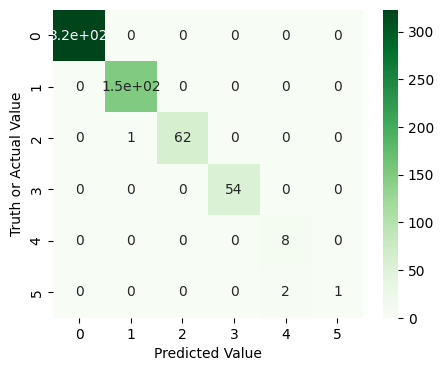

In [36]:
plt.figure(figsize = (5,4))
sns.heatmap(test, annot = True, cmap = 'Greens')
plt.xlabel('Predicted Value')
plt.ylabel('Truth or Actual Value')
plt.show()

#### 2. Các thông số đánh giá: Accuracy, Precision, Recall

 Độ so khớp của mô hình với dữ liệu (%)

In [37]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.995


Với confusion matrix ở trên do ở đây ta thực hiên phân lớp tới 6 loại label khác nhau, nên việc tính toán các giá trị TP FP TN FN có vẻ khá tốn thời gian nên chúng ta sẽ sử dụng hàm classification_report để tính toán ra được giá trị precision, recall tương ứng với từng label.

In [38]:
#Precision Recall
print(metrics.classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       323
         2.0       0.99      1.00      1.00       149
         3.0       1.00      0.98      0.99        63
         4.0       1.00      1.00      1.00        54
         5.0       0.80      1.00      0.89         8
         6.0       1.00      0.33      0.50         3

    accuracy                           0.99       600
   macro avg       0.97      0.89      0.90       600
weighted avg       1.00      0.99      0.99       600



**NHẬN XÉT:**

Với mô hình được sử dụng ở trên có vẻ accuracy mang lại có vẻ khá cao và chính xác, nhưng không thuộc vào trường hợp overfitting

## MÔ HÌNH 2: **LOGISTIC REGRESSION**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

In [39]:
# Models Logistic Regression
from sklearn.linear_model import LogisticRegression

Sau đó fix dữ liệu train với model

In [40]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    mymodel = LogisticRegression(max_iter = 120)
    mymodel.fit(X_train, y_train)

Tập dự đoán 

In [41]:
predicted_output = mymodel.predict(X_test)
predicted_output

array([2., 1., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 5., 1., 1., 2.,
       2., 2., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1.,
       4., 1., 2., 3., 2., 2., 1., 1., 1., 1., 2., 2., 1., 3., 1., 1., 1.,
       3., 2., 1., 1., 3., 3., 1., 1., 1., 2., 2., 2., 2., 1., 1., 1., 1.,
       1., 2., 1., 1., 4., 1., 1., 1., 2., 3., 1., 1., 2., 4., 2., 1., 3.,
       1., 2., 2., 4., 3., 1., 2., 1., 3., 2., 1., 1., 2., 2., 1., 1., 4.,
       1., 3., 2., 3., 2., 1., 4., 1., 3., 1., 1., 1., 1., 2., 1., 3., 2.,
       3., 1., 4., 1., 1., 2., 1., 2., 1., 3., 1., 1., 1., 3., 1., 2., 3.,
       2., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 2., 2., 1., 1., 2., 1.,
       1., 1., 1., 1., 4., 1., 2., 4., 1., 1., 4., 5., 1., 4., 2., 2., 1.,
       1., 1., 1., 2., 1., 4., 2., 4., 1., 4., 1., 2., 1., 2., 1., 1., 1.,
       3., 1., 1., 3., 1., 1., 2., 2., 2., 4., 1., 4., 2., 1., 1., 1., 1.,
       3., 1., 1., 4., 3., 2., 1., 4., 3., 1., 1., 1., 1., 2., 2., 1., 1.,
       3., 1., 1., 1., 1.

### **ĐÁNH GIÁ MÔ HÌNH**

#### 1. **Confusion Matrix** (ma trận kiểm chứng tính đúng sai giữa true label và predicted label)

In [42]:
test = confusion_matrix(y_test, predicted_output)
test

array([[318,   5,   0,   0,   0,   0],
       [ 11, 133,   0,   5,   0,   0],
       [  0,   1,  55,   4,   3,   0],
       [  0,  10,   3,  41,   0,   0],
       [  0,   0,   3,   0,   4,   1],
       [  0,   0,   0,   0,   2,   1]], dtype=int64)

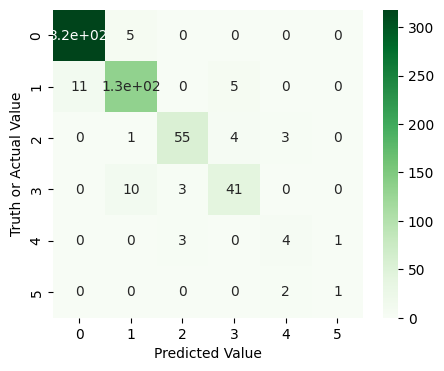

In [43]:
plt.figure(figsize = (5,4))
sns.heatmap(test, annot = True, cmap = 'Greens')
plt.xlabel('Predicted Value')
plt.ylabel('Truth or Actual Value')
plt.show()

#### 2. Các thông số đánh giá: Accuracy, Precision, Recall

 Độ so khớp của mô hình với dữ liệu (%)

In [44]:
print("Accuracy:", metrics.accuracy_score(y_test, predicted_output))

Accuracy: 0.92


Với confusion matrix ở trên do ở đây ta thực hiên phân lớp tới 6 loại label khác nhau, nên việc tính toán các giá trị TP FP TN FN có vẻ khá tốn thời gian nên chúng ta sẽ sử dụng hàm classification_report để tính toán ra được giá trị precision, recall tương ứng với từng label.

In [45]:
#Precision Recall
print(metrics.classification_report(y_test, predicted_output)) 

              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98       323
         2.0       0.89      0.89      0.89       149
         3.0       0.90      0.87      0.89        63
         4.0       0.82      0.76      0.79        54
         5.0       0.44      0.50      0.47         8
         6.0       0.50      0.33      0.40         3

    accuracy                           0.92       600
   macro avg       0.75      0.72      0.74       600
weighted avg       0.92      0.92      0.92       600



**NHẬN XÉT:**

Với mô hình được sử dụng ở trên có vẻ accuracy mang lại có vẻ khá cao và chính xác, nhưng không thuộc vào trường hợp overfitting

# SO SÁNH 2 MÔ HÌNH